# Comprehensive Benchmarking of Regression Algorithms on Synthetic Data

## Step 1: Import Libraries and Setup

In [44]:
# Cell 1: Import Libraries and Setup
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, TheilSenRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import statsmodels.api as sm
import time
import os
from IPython.display import display
from datetime import datetime
import warnings

%matplotlib inline

# Define output_dir
output_dir = f'Comprehensive_Benchmarking_of_Regression_Algorithms_on_Synthetic_Data_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
os.makedirs(output_dir, exist_ok=True)

## Step 2: Data Generation

In [45]:
# Cell 2: Data Generation
def generate_data(n_samples=200, n_features=3):
    np.random.seed(42)
    X = np.random.rand(n_samples, n_features)
    y = 3 + 2*X[:, 0] + 5*X[:, 1]**2 - X[:, 2] + np.random.randn(n_samples)*0.5
    return X, y

X, y = generate_data()
print(f"Dataset shape - X: {X.shape}, y: {y.shape}")

Dataset shape - X: (200, 3), y: (200,)


## Step 3: Outlier Detection

In [46]:
# Cell 3: Outlier Detection
def detect_outliers(X, y, threshold=1.5):
    Q1, Q3 = np.percentile(y, [25, 75])
    IQR = Q3 - Q1
    mask = (y >= Q1 - threshold*IQR) & (y <= Q3 + threshold*IQR)
    return X[mask], y[mask]

X, y = detect_outliers(X, y)
print(f"After outlier removal - X: {X.shape}, y: {y.shape}")

After outlier removal - X: (200, 3), y: (200,)


## Step 4: Data Preparation

In [47]:
# Cell 4: Data Preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (160, 3), Test set: (40, 3)


## Step 5: Define Models

In [48]:
# Cell 5: Define Models
# Add warning filters for specific models
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')  # Suppress UserWarning for sklearn (e.g., deprecated parameters)
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')  # Suppress FutureWarning for sklearn API changes

models = {
    'Linear': LinearRegression(),
    'Ridge': RandomizedSearchCV(Ridge(), {'alpha': [0.1, 1.0, 10.0]}, n_iter=3, random_state=42, n_jobs=1),  # n_jobs=1 to suppress joblib warning
    'Lasso': RandomizedSearchCV(Lasso(), {'alpha': [0.01, 0.1, 1.0]}, n_iter=3, random_state=42, n_jobs=1),
    'ElasticNet': RandomizedSearchCV(ElasticNet(), {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.3, 0.5, 0.7]}, n_iter=3, random_state=42, n_jobs=1),
    'Polynomial': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(max_depth=3, random_state=42),
    'RandomForest': RandomizedSearchCV(RandomForestRegressor(random_state=42), {'n_estimators': [50, 100], 'max_depth': [3, 5]}, n_iter=3, random_state=42, n_jobs=1),
    'GradientBoosting': RandomizedSearchCV(GradientBoostingRegressor(random_state=42), {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}, n_iter=3, random_state=42, n_jobs=1),
    'SVR': RandomizedSearchCV(SVR(), {'C': [10, 100], 'gamma': [0.01, 0.1]}, n_iter=3, random_state=42, n_jobs=1),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'NeuralNetwork': MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, tol=1e-4, random_state=42),
    'GaussianProcess': GaussianProcessRegressor(kernel=C(1.0)*RBF(1.0, (1e-2, 1e2)), random_state=42, alpha=1e-6),
    'BayesianRidge': BayesianRidge(),
    'Huber': HuberRegressor(epsilon=1.35, alpha=0.0001),
    'TheilSen': TheilSenRegressor(random_state=42)
}
try:
    from xgboost import XGBRegressor
    models['XGBoost'] = RandomizedSearchCV(XGBRegressor(random_state=42, n_jobs=1), {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}, n_iter=3, random_state=42, n_jobs=1)
except ImportError:
    print('XGBoost not installed.')
try:
    from lightgbm import LGBMRegressor
    models['LightGBM'] = RandomizedSearchCV(LGBMRegressor(random_state=42, verbose=-1), {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}, n_iter=3, random_state=42, n_jobs=1)
except ImportError:
    print('LightGBM not installed.')
try:
    from catboost import CatBoostRegressor
    models['CatBoost'] = RandomizedSearchCV(CatBoostRegressor(random_state=42, verbose=0), {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}, n_iter=3, random_state=42, n_jobs=1)
except ImportError:
    print('CatBoost not installed.')
print(f'Models defined: {list(models.keys())}')

Models defined: ['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'Polynomial', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'SVR', 'KNN', 'NeuralNetwork', 'GaussianProcess', 'BayesianRidge', 'Huber', 'TheilSen', 'XGBoost', 'LightGBM', 'CatBoost']


## Step 6: Model Evaluation Function

In [49]:
# Cell 6: Model Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test, name, cv=5):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
    cv_mse = -cv_scores.mean()
    print(f'{name}: MSE={mse:.4f}, R²={r2:.4f}, CV-MSE={cv_mse:.4f}, Time={train_time:.2f}s')
    return mse, r2, cv_mse, train_time, y_pred

## Step 7: Statistical Significance for Linear Models

In [50]:
# Cell 7: Statistical Significance for Linear Models
def get_statsmodel_results(X_train, y_train, X_test, name, model=None):
    if model is None:  # For Linear and Polynomial, use statsmodels OLS
        X_train_sm = sm.add_constant(X_train)
        sm_model = sm.OLS(y_train, X_train_sm).fit()
        coefs = sm_model.params[1:]
        p_values = sm_model.pvalues[1:]
        conf_int = sm_model.conf_int()[1:]
    else:  # For Ridge, Lasso, ElasticNet, etc., use sklearn model coefficients
        best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
        coefs = best_model.coef_
        # Since sklearn doesn't provide p-values or CIs, we'll use statsmodels for those
        X_train_sm = sm.add_constant(X_train)
        sm_model = sm.OLS(y_train, X_train_sm).fit()  # Use OLS for p-values/CI as approximation
        p_values = sm_model.pvalues[1:]
        conf_int = sm_model.conf_int()[1:]
        # Warn if coefficients differ significantly between sklearn and statsmodels
        if not np.allclose(coefs, sm_model.params[1:], rtol=1e-2) and name in ['Ridge', 'Lasso', 'ElasticNet']:
            warnings.warn(f"{name}: Coefficients from sklearn ({coefs}) differ from statsmodels ({sm_model.params[1:]}). "
                          f"For regularized models, p-values and CIs are approximations based on unregularized OLS.")

    print(f'\n{name} Stats:')
    for i, (coef, p, ci) in enumerate(zip(coefs, p_values, conf_int)):
        print(f'  Feature {i+1}: Coef={coef:.4f}, p-value={p:.4f}, CI=({ci[0]:.4f}, {ci[1]:.4f})')
    return sm_model

## Step 8: Train and Evaluate Models

In [51]:
# Cell 8: Train and Evaluate Models
results = {}
predictions = {}
for name, model in models.items():
    X_t, X_te = (X_train_poly, X_test_poly) if name == 'Polynomial' else (X_train_scaled, X_test_scaled) if name in ['SVR', 'NeuralNetwork', 'GaussianProcess'] else (X_train, X_test)
    if name == 'GaussianProcess':
        subset_size = len(X_train_scaled)  # Use full training set for better performance
        mse, r2, cv_mse, train_time, y_pred = evaluate_model(model, X_train_scaled[:subset_size], X_test_scaled, y_train[:subset_size], y_test, name)
        _, std = model.predict(X_test_scaled, return_std=True)
        predictions[name] = (y_pred, std)
    else:
        mse, r2, cv_mse, train_time, y_pred = evaluate_model(model, X_t, X_te, y_train, y_test, name)
        predictions[name] = (y_pred, None)
    results[name] = (mse, r2, cv_mse, train_time)
    if name in ['Linear', 'Ridge', 'Lasso', 'BayesianRidge', 'Huber', 'TheilSen']:
        get_statsmodel_results(X_train, y_train, X_test, name, model=model)

Linear: MSE=0.3965, R²=0.8847, CV-MSE=0.4020, Time=0.00s

Linear Stats:
  Feature 1: Coef=1.9786, p-value=0.0000, CI=(1.6348, 2.3224)
  Feature 2: Coef=4.8217, p-value=0.0000, CI=(4.4934, 5.1500)
  Feature 3: Coef=-0.9944, p-value=0.0000, CI=(-1.3270, -0.6617)
Ridge: MSE=0.4004, R²=0.8835, CV-MSE=0.4023, Time=0.07s

Ridge Stats:
  Feature 1: Coef=1.9657, p-value=0.0000, CI=(1.6348, 2.3224)
  Feature 2: Coef=4.7888, p-value=0.0000, CI=(4.4934, 5.1500)
  Feature 3: Coef=-0.9847, p-value=0.0000, CI=(-1.3270, -0.6617)
Lasso: MSE=0.4135, R²=0.8797, CV-MSE=0.4071, Time=0.04s

Lasso Stats:
  Feature 1: Coef=1.8582, p-value=0.0000, CI=(1.6348, 2.3224)
  Feature 2: Coef=4.7120, p-value=0.0000, CI=(4.4934, 5.1500)
  Feature 3: Coef=-0.8670, p-value=0.0000, CI=(-1.3270, -0.6617)
ElasticNet: MSE=0.4446, R²=0.8707, CV-MSE=0.4159, Time=0.04s
Polynomial: MSE=0.1853, R²=0.9461, CV-MSE=0.3092, Time=0.00s
DecisionTree: MSE=0.8349, R²=0.7572, CV-MSE=0.6343, Time=0.00s
RandomForest: MSE=0.3459, R²=0.8994,

## Step 9: Model Comparison Table

In [52]:
# Cell 9: Model Comparison Table
results_df = pd.DataFrame({
    'Model': [name for name, _ in results.items()],
    'MSE': [res[0] for _, res in results.items()],
    'R²': [res[1] for _, res in results.items()],
    'CV-MSE': [res[2] for _, res in results.items()],
    'Train Time (s)': [res[3] for _, res in results.items()]
}).sort_values('MSE')
results_df.to_csv(os.path.join(output_dir, 'results.csv'), index=False)
print('\nModel Comparison Table:')
print(results_df.round(4))


Model Comparison Table:
               Model     MSE      R²  CV-MSE  Train Time (s)
4         Polynomial  0.1853  0.9461  0.3092          0.0020
10     NeuralNetwork  0.2196  0.9361  0.3840          0.6388
8                SVR  0.2203  0.9359  0.2874          0.0950
17          CatBoost  0.2467  0.9283  0.3463          1.4458
7   GradientBoosting  0.2847  0.9172  0.4123          1.1675
15           XGBoost  0.2974  0.9135  0.3907          0.8005
16          LightGBM  0.3213  0.9066  0.3866          0.2971
6       RandomForest  0.3459  0.8994  0.3887          2.2378
13             Huber  0.3938  0.8855  0.4048          0.0060
0             Linear  0.3965  0.8847  0.4020          0.0010
12     BayesianRidge  0.3981  0.8842  0.4020          0.0020
1              Ridge  0.4004  0.8835  0.4023          0.0660
2              Lasso  0.4135  0.8797  0.4071          0.0410
14          TheilSen  0.4186  0.8783  0.4108          0.4695
9                KNN  0.4425  0.8713  0.4201          0.0000

## Step 10: Learning Curve Function

In [53]:
# Cell 10: Learning Curve Function
def plot_learning_curve(model, X, y, name):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 5))
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    plt.plot(train_sizes, train_scores_mean, label=f'{name} Train')
    plt.plot(train_sizes, test_scores_mean, label=f'{name} Test')
    return train_scores_mean, test_scores_mean

## Step 11: Performance Visualization - Bar Charts

In [54]:
def plot_mse_bar_chart(models_list, mse_values, output_dir):
    n_models = len(models_list)
    group_size = 10  # Display 10 models at a time
    for group in range(0, n_models, group_size):
        start, end = group, min(group + group_size, n_models)
        group_models = models_list[start:end]
        group_mse = mse_values[start:end]

        fig = plt.figure(figsize=(10, 5))
        plt.barh(group_models, group_mse, color='indianred', height=0.25)
        plt.title(f'Mean Squared Error (Lower is Better) - Models {start+1} to {end}', fontsize=14)
        plt.xlabel('MSE', fontsize=12)
        plt.ylabel('Models', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        for i, v in enumerate(group_mse):
            plt.text(v + 0.02, i, f'{v:.4f}', va='center', ha='left', fontsize=10)
        plt.tight_layout(pad=2.0)
        fig_path = os.path.join(output_dir, f'mse_bar_chart_group_{start+1}_to_{end}.png')
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        display(fig)
        plt.close(fig)

def plot_r2_bar_chart(models_list, r2_values, output_dir):
    n_models = len(models_list)
    group_size = 10  # Display 10 models at a time
    for group in range(0, n_models, group_size):
        start, end = group, min(group + group_size, n_models)
        group_models = models_list[start:end]
        group_r2 = r2_values[start:end]

        fig = plt.figure(figsize=(10, 5))
        plt.barh(group_models, group_r2, color='steelblue', height=0.25)
        plt.title(f'R² Score (Higher is Better) - Models {start+1} to {end}', fontsize=14)
        plt.xlabel('R²', fontsize=12)
        plt.ylabel('Models', fontsize=12)
        plt.xlim(0, 1.1)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        for i, v in enumerate(group_r2):
            plt.text(v + 0.02, i, f'{v:.4f}', va='center', ha='left', fontsize=10)
        plt.tight_layout(pad=2.0)
        fig_path = os.path.join(output_dir, f'r2_bar_chart_group_{start+1}_to_{end}.png')
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        display(fig)
        plt.close(fig)

def plot_cv_mse_bar_chart(models_list, cv_mse_values, output_dir):
    n_models = len(models_list)
    group_size = 10  # Display 10 models at a time
    for group in range(0, n_models, group_size):
        start, end = group, min(group + group_size, n_models)
        group_models = models_list[start:end]
        group_cv_mse = cv_mse_values[start:end]

        fig = plt.figure(figsize=(10, 5))
        plt.barh(group_models, group_cv_mse, color='forestgreen', height=0.25)
        plt.title(f'Cross-Validation MSE (Lower is Better) - Models {start+1} to {end}', fontsize=14)
        plt.xlabel('CV-MSE', fontsize=12)
        plt.ylabel('Models', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        for i, v in enumerate(group_cv_mse):
            plt.text(v + 0.02, i, f'{v:.4f}', va='center', ha='left', fontsize=10)
        plt.tight_layout(pad=2.0)
        fig_path = os.path.join(output_dir, f'cv_mse_bar_chart_group_{start+1}_to_{end}.png')
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        display(fig)
        plt.close(fig)

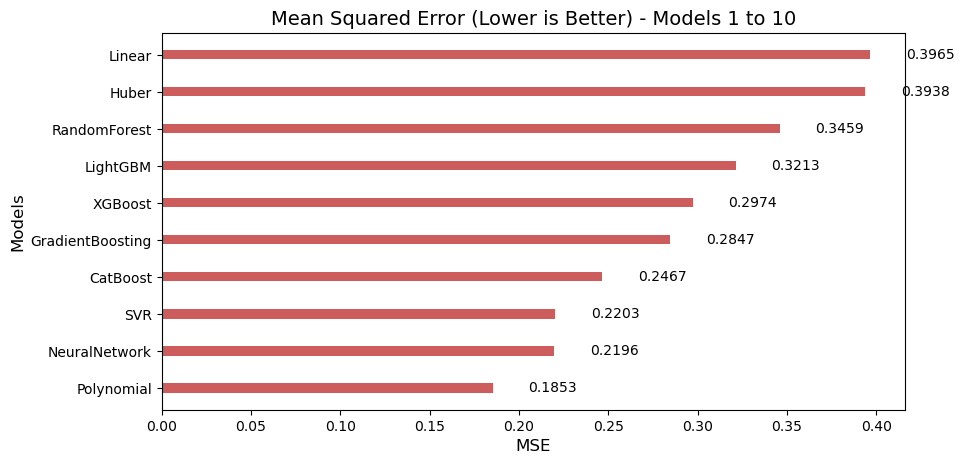

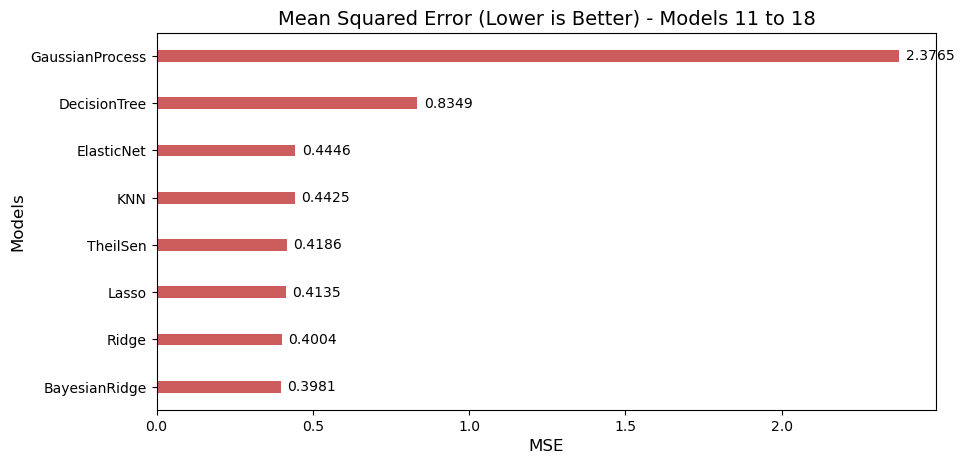

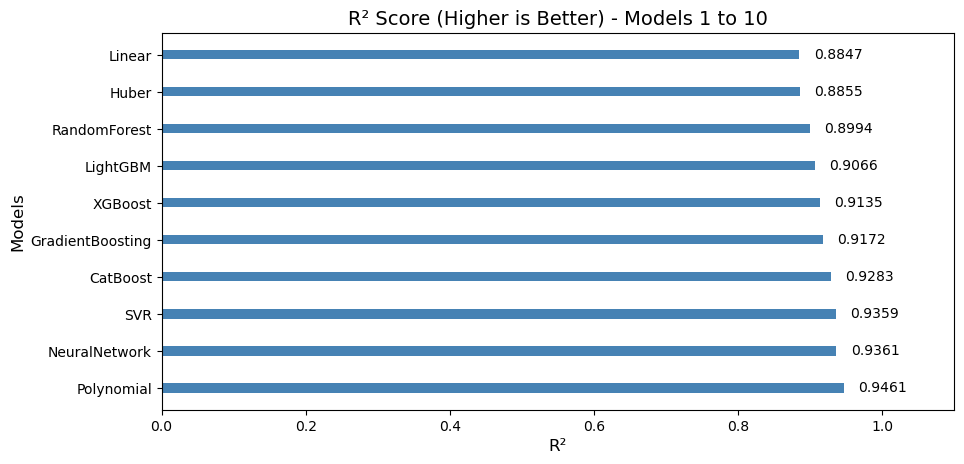

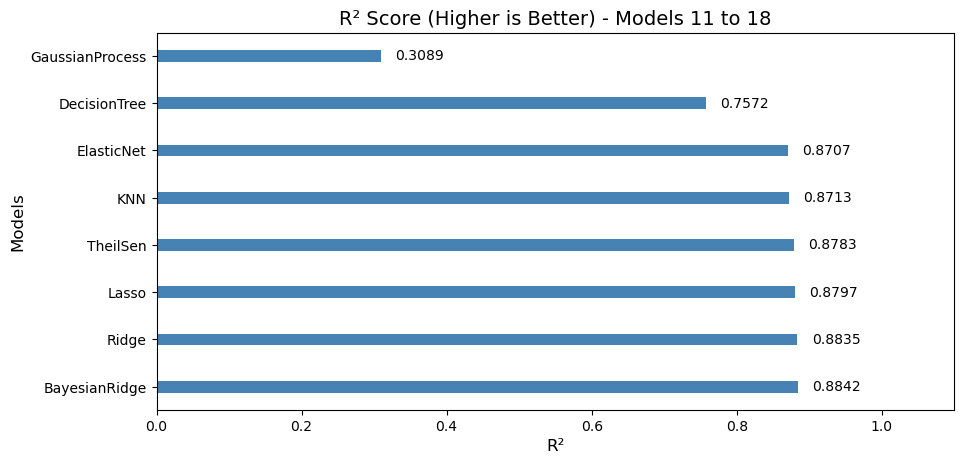

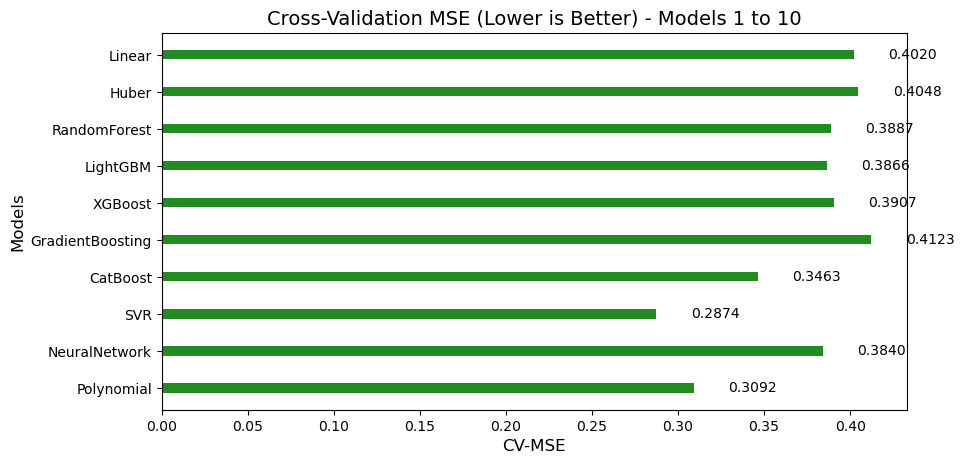

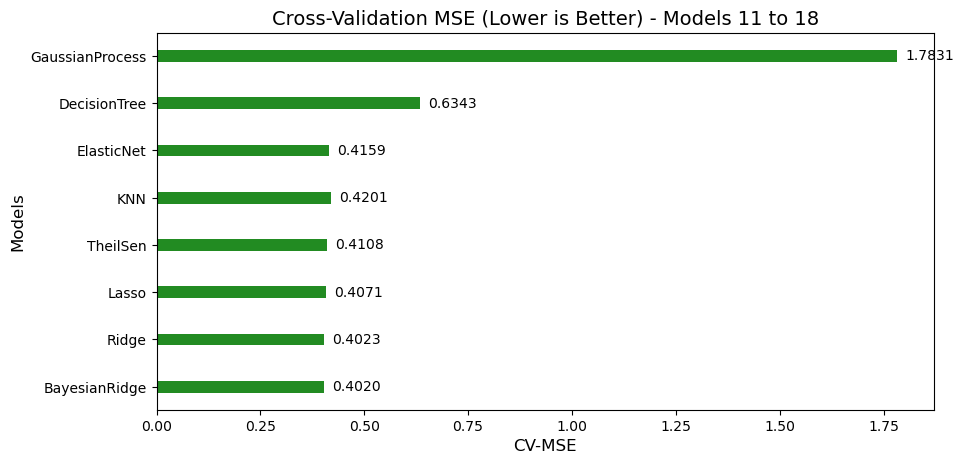

In [55]:
# Cell 11: Performance Visualization - Bar Charts
%matplotlib inline
sorted_results = sorted(results.items(), key=lambda x: x[1][0])
models_list = [name for name, _ in sorted_results]
mse_values = [res[0] for _, res in sorted_results]
r2_values = [res[1] for _, res in sorted_results]
cv_mse_values = [res[2] for _, res in sorted_results]

# Call the three separate functions
plot_mse_bar_chart(models_list, mse_values, output_dir)
plot_r2_bar_chart(models_list, r2_values, output_dir)
plot_cv_mse_bar_chart(models_list, cv_mse_values, output_dir)

## Step 12: Performance Visualization - Radar Chart

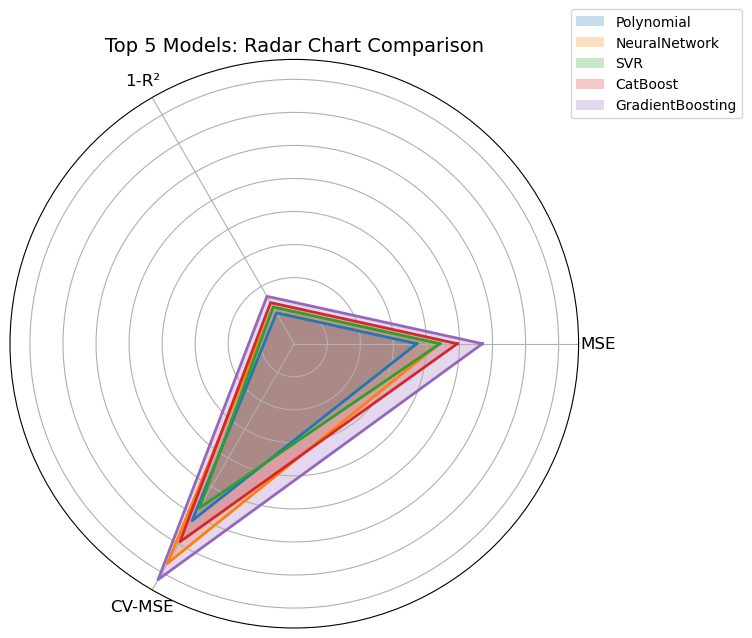

<Figure size 640x480 with 0 Axes>

In [56]:
# Cell 12: Performance Visualization - Radar Chart
%matplotlib inline
top_models = sorted_results[:5]
metrics = ['MSE', '1-R²', 'CV-MSE']
values = [[res[0], 1-res[1], res[2]] for _, res in top_models]
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, (name, _) in enumerate(top_models):
    data = values[i] + values[i][:1]
    ax.fill(angles, data, alpha=0.25, label=name)
    ax.plot(angles, data, linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)
plt.title('Top 5 Models: Radar Chart Comparison', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.tight_layout(pad=2.0)
plt.pause(0.1)  # Ensure rendering completes
plt.savefig(os.path.join(output_dir, 'radar_chart.png'), dpi=300, bbox_inches='tight')
plt.show()

## Step 13: Feature Importance for Tree-Based Models

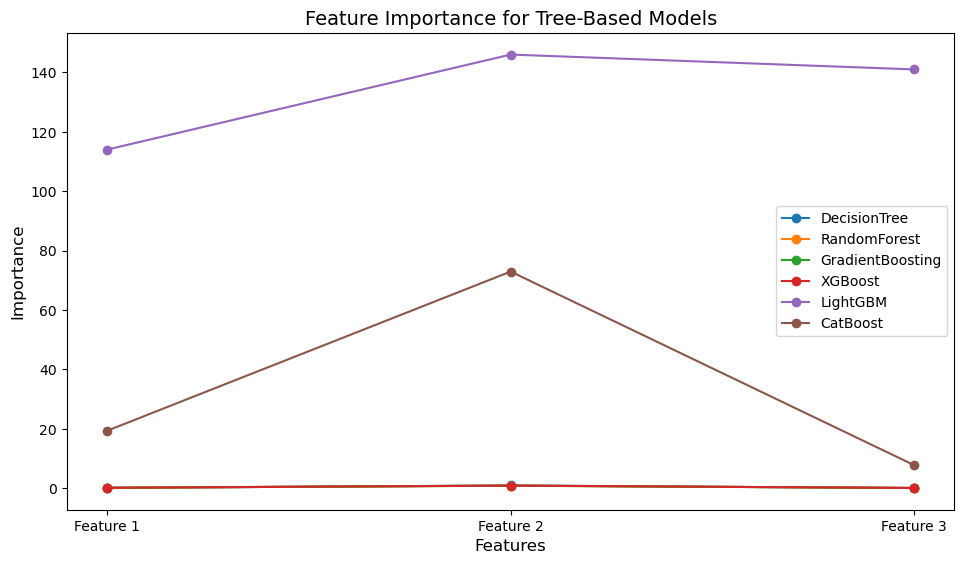

<Figure size 640x480 with 0 Axes>

In [57]:
# Cell 13: Feature Importance for Tree-Based Models
%matplotlib inline
tree_models = ['DecisionTree', 'RandomForest', 'GradientBoosting'] + (['XGBoost'] if 'XGBoost' in models else []) + (['LightGBM'] if 'LightGBM' in models else []) + (['CatBoost'] if 'CatBoost' in models else [])
if tree_models:
    plt.figure(figsize=(10, 6))
    for name in tree_models:
        model = models[name].best_estimator_ if hasattr(models[name], 'best_estimator_') else models[name]
        model.fit(X_train, y_train)
        plt.plot([f'Feature {i+1}' for i in range(X.shape[1])], model.feature_importances_, marker='o', label=name)
    plt.title('Feature Importance for Tree-Based Models', fontsize=14)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10)
    plt.tight_layout(pad=2.0)
    plt.pause(0.1)  # Ensure rendering completes
    plt.savefig(os.path.join(output_dir, 'feature_importance.png'), dpi=300, bbox_inches='tight')
    plt.show()

## Step 14: Residual Plot for Top 3 Models

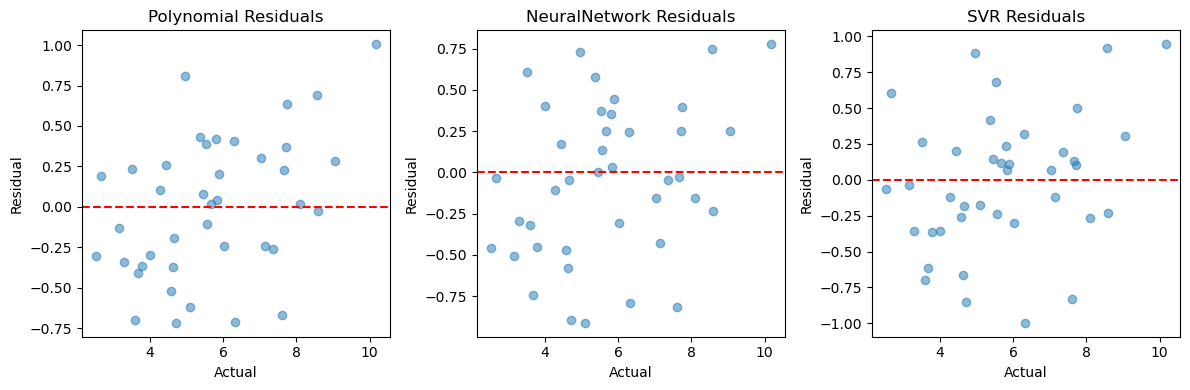

In [58]:
# Cell 14: Residual Plot for Top 3 Models
plt.figure(figsize=(12, 4))
for i, (name, _) in enumerate(sorted_results[:3], 1):
    plt.subplot(1, 3, i)
    y_pred, _ = predictions[name]
    residuals = y_test - y_pred
    plt.scatter(y_test, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{name} Residuals')
    plt.xlabel('Actual')
    plt.ylabel('Residual')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'residual_plot.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Step 15: Prediction Intervals for Gaussian Process

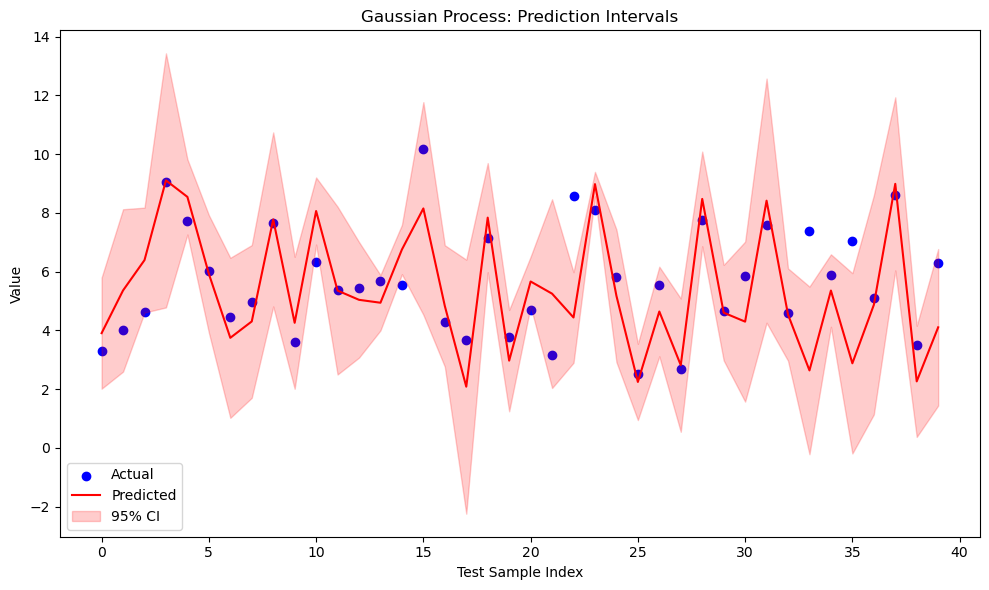

In [59]:
# Cell 15: Prediction Intervals for Gaussian Process
if 'GaussianProcess' in models:
    plt.figure(figsize=(10, 6))
    y_pred, std = predictions['GaussianProcess']
    plt.scatter(range(len(y_test)), y_test, label='Actual', color='blue')
    plt.plot(range(len(y_pred)), y_pred, label='Predicted', color='red')
    plt.fill_between(range(len(y_pred)), y_pred - 1.96*std, y_pred + 1.96*std, alpha=0.2, color='red', label='95% CI')
    plt.title('Gaussian Process: Prediction Intervals')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'prediction_intervals.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Step 16: Learning Curves for Top 3 Models

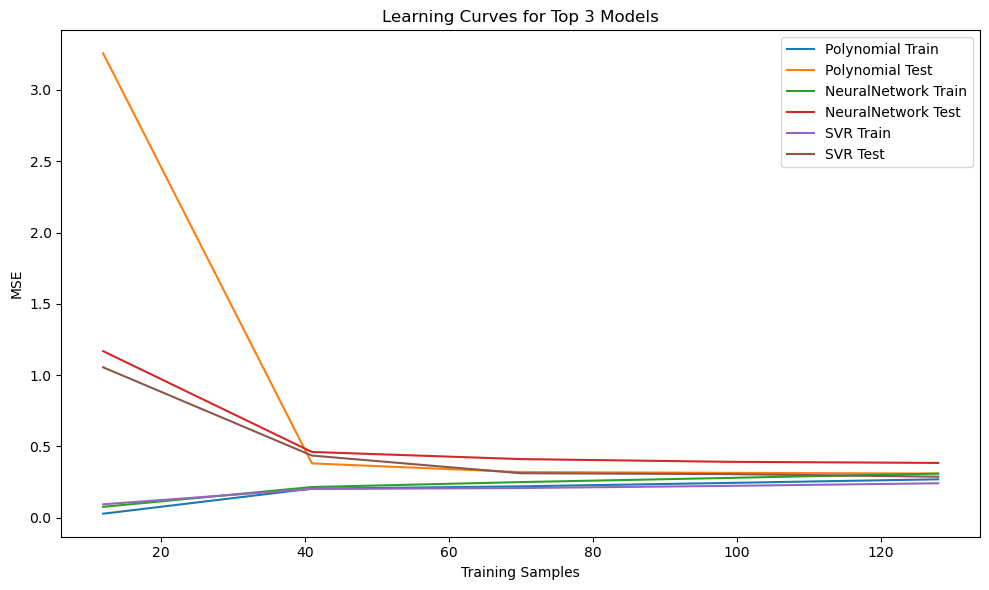

In [60]:
# Cell 16: Learning Curves for Top 3 Models
plt.figure(figsize=(10, 6))
for name, _ in sorted_results[:3]:
    model = models[name].best_estimator_ if hasattr(models[name], 'best_estimator_') else models[name]
    X_t = X_train_poly if name == 'Polynomial' else X_train_scaled if name in ['SVR', 'NeuralNetwork', 'GaussianProcess'] else X_train
    plot_learning_curve(model, X_t, y_train, name)
plt.title('Learning Curves for Top 3 Models')
plt.xlabel('Training Samples')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'learning_curves.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Step 17: Heatmap of Normalized Performance

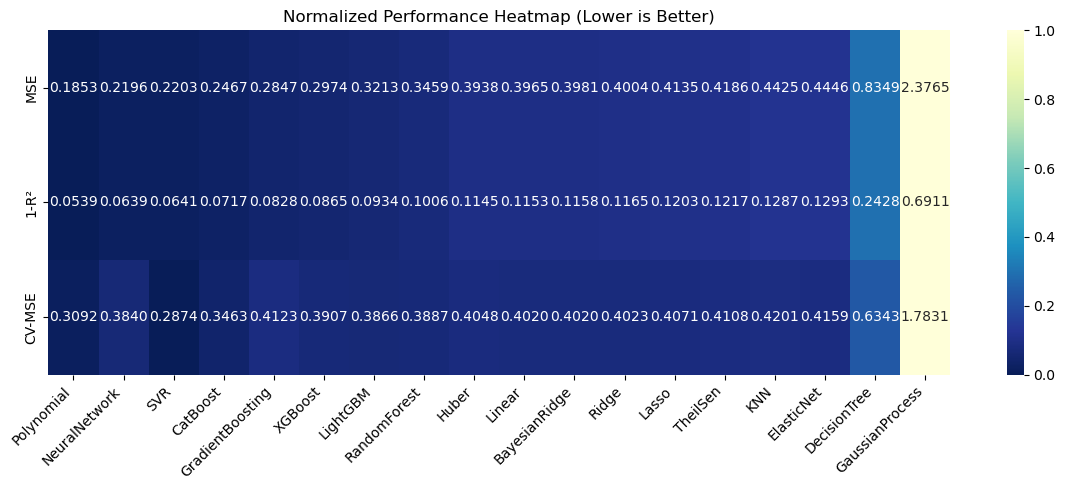

In [61]:
# Cell 17: Heatmap of Normalized Performance
performance_data = np.array([mse_values, [1-r2 for r2 in r2_values], cv_mse_values])
performance_norm = (performance_data - performance_data.min(axis=1, keepdims=True)) / (performance_data.max(axis=1, keepdims=True) - performance_data.min(axis=1, keepdims=True))
plt.figure(figsize=(12, 5))
sns.heatmap(performance_norm, annot=performance_data, fmt='.4f', cmap='YlGnBu_r', xticklabels=models_list, yticklabels=['MSE', '1-R²', 'CV-MSE'])
plt.title('Normalized Performance Heatmap (Lower is Better)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()